In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Configuration d'affichage
pd.set_option('display.max_columns', None)
plt.style.use('seaborn')
sns.set_palette("crest")

In [83]:
# --- 1. Chargement du jeu de données et nettoyage des noms ---

try:
    df = pd.read_csv("autos.csv", encoding='latin1')
except FileNotFoundError:
    print("Erreur : Le fichier 'autos.csv' est introuvable. Veuillez le placer dans le répertoire courant.")
    exit()

# Nettoyage des noms des colonnes
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

print(f"Jeu de données chargé : {df.shape[0]} lignes et {df.shape[1]} colonnes")
print("\n🔎 Informations initiales :")
df.info()

Jeu de données chargé : 371528 lignes et 21 colonnes

🔎 Informations initiales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   index                371528 non-null  int64 
 1   datecrawled          371528 non-null  object
 2   name                 371528 non-null  object
 3   seller               371528 non-null  object
 4   offertype            371528 non-null  object
 5   price                371528 non-null  int64 
 6   abtest               371528 non-null  object
 7   vehicletype          333659 non-null  object
 8   yearofregistration   371528 non-null  int64 
 9   gearbox              351319 non-null  object
 10  powerps              371528 non-null  int64 
 11  model                351044 non-null  object
 12  kilometer            371528 non-null  int64 
 13  monthofregistration  371528 non-null  int64 
 14  fue

In [84]:
# --- 2. Suppression des colonnes non pertinentes ---

colonnes_a_supprimer = [
    'index',
    'datecrawled',
    'name',
    'seller',
    'offertype',
    'abtest',
    'datecreated',
    'nrofpictures',
    'postalcode',
    'lastseen'
]

# Suppression des colonnes
df.drop(columns=colonnes_a_supprimer, inplace=True)

print(f"\n✅ Colonnes non pertinentes supprimées : {colonnes_a_supprimer}")
print(f"Colonnes restantes : {df.columns.tolist()}")


✅ Colonnes non pertinentes supprimées : ['index', 'datecrawled', 'name', 'seller', 'offertype', 'abtest', 'datecreated', 'nrofpictures', 'postalcode', 'lastseen']
Colonnes restantes : ['price', 'vehicletype', 'yearofregistration', 'gearbox', 'powerps', 'model', 'kilometer', 'monthofregistration', 'fueltype', 'brand', 'notrepaireddamage']


In [85]:
# --- 3. Traitement des Doublons ---

nb_doublons = df.duplicated().sum()
df = df.drop_duplicates()
print(f"\nNombre de doublons supprimés : {nb_doublons}")
print(f"Nouvelle taille du dataset : {df.shape}")


Nombre de doublons supprimés : 28503
Nouvelle taille du dataset : (343025, 11)


In [86]:
# --- 4. Traitement des Doublons ---

lignes_doublons = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Nombre de doublons supprimés : {lignes_doublons}. Taille actuelle : {df.shape}")




Nombre de doublons supprimés : 0. Taille actuelle : (343025, 11)


In [87]:
# --- 5. Traitement des valeurs manquantes (Suppression + Imputation simple) ---

# a) Suppression des lignes sans information essentielle (Modèle et Boîte de Vitesse)
# On choisit de supprimer les NaNs pour les features les plus critiques.
lignes_avant_drop = df.shape[0]
df = df.dropna(subset=['model', 'gearbox'])
lignes_supprimees_essentiel = lignes_avant_drop - df.shape[0]

print(f"\nLignes sans 'model' ou 'gearbox' supprimées : {lignes_supprimees_essentiel}")


Lignes sans 'model' ou 'gearbox' supprimées : 33604


In [88]:
# --- 6. Traitement des valeurs aberrantes (Outliers) ---

lignes_avant_outlier = df.shape[0]

# a) Filtrage du prix (variable cible)
# On supprime les prix <= 100 (non significatifs, erreurs ou prix symboliques)
df = df[df['price'] > 100]

# b) Filtrage de l'année d'enregistrement
# On garde les années réalistes (entre 1950 et 2025)
df = df[(df['yearofregistration'] >= 1950) & (df['yearofregistration'] <= 2025)]

# c) Filtrage de la puissance moteur (powerps)
# On supprime les valeurs non réalistes ou extrêmes (Puissance entre 50 PS et 500 PS)
df = df[(df['powerps'] >= 50) & (df['powerps'] <= 500)].copy()

lignes_supprimees_outlier = lignes_avant_outlier - df.shape[0]

print(f"\nLignes avec valeurs aberrantes (prix, année, puissance) supprimées : {lignes_supprimees_outlier}")


Lignes avec valeurs aberrantes (prix, année, puissance) supprimées : 34576


In [89]:
print("\n--- Résumé du nettoyage de données ---")
print(f"Dimensions finales du dataset : {df.shape}")
print(f"Colonnes finales : {df.columns.tolist()}")
print("\nStatistiques des variables numériques restantes (pour vérification):")
print(df.describe().T)

print("\nLe jeu de données est maintenant nettoyé et prêt pour l'analyse.")


--- Résumé du nettoyage de données ---
Dimensions finales du dataset : (274845, 11)
Colonnes finales : ['price', 'vehicletype', 'yearofregistration', 'gearbox', 'powerps', 'model', 'kilometer', 'monthofregistration', 'fueltype', 'brand', 'notrepaireddamage']

Statistiques des variables numériques restantes (pour vérification):
                        count      mean       std     min       25%       50%  \
price               274845.00  10043.15 550302.17  101.00   1500.00   3550.00   
yearofregistration  274845.00   2003.82      6.79 1950.00   1999.00   2004.00   
powerps             274845.00    127.37     58.96   50.00     84.00    116.00   
kilometer           274845.00 125518.57  39127.90 5000.00 100000.00 150000.00   
monthofregistration 274845.00      6.03      3.56    0.00      3.00      6.00   

                          75%         max  
price                 8000.00 99999999.00  
yearofregistration    2008.00     2019.00  
powerps                150.00      500.00  
kilomet

# Featuring
---
## 1. Imports et Configuration

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('seaborn')
sns.set_palette("crest")
%matplotlib inline

# Configuration pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print("Imports réussis")

Imports réussis


---
## 2. Chargement des Données Nettoyées

In [91]:
# Charger les données nettoyées (output du notebook de data cleaning)
# Note: Assurez-vous que le notebook de data cleaning a été exécuté et a sauvegardé le fichier
# df = pd.read_csv('autos_cleaned.csv', encoding='latin1')

print("="*70)
print("CHARGEMENT DES DONNÉES NETTOYÉES")
print("="*70)
print(f"\nShape du dataset: {df.shape}")
print(f"Lignes: {df.shape[0]:,}")
print(f"Colonnes: {df.shape[1]}")
print(f"\nValeurs manquantes totales: {df.isnull().sum().sum()}")

CHARGEMENT DES DONNÉES NETTOYÉES

Shape du dataset: (274845, 11)
Lignes: 274,845
Colonnes: 11

Valeurs manquantes totales: 67241


In [92]:
# Aperçu des données
print("\nAperçu des premières lignes:")
display(df.head())


Aperçu des premières lignes:


,price,vehicletype,yearofregistration,gearbox,powerps,model,kilometer,monthofregistration,fueltype,brand,notrepaireddamage
2,9800,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN
3,1500,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein
4,3600,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein
5,650,limousine,1995,manuell,102,3er,150000,10,benzin,bmw,ja
6,2200,cabrio,2004,manuell,109,2_reihe,150000,8,benzin,peugeot,nein


In [93]:
# Informations sur les colonnes
print("\nInformations sur les colonnes:")
print(df.info())


Informations sur les colonnes:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 274845 entries, 2 to 371527
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   price                274845 non-null  int64 
 1   vehicletype          259113 non-null  object
 2   yearofregistration   274845 non-null  int64 
 3   gearbox              274845 non-null  object
 4   powerps              274845 non-null  int64 
 5   model                274845 non-null  object
 6   kilometer            274845 non-null  int64 
 7   monthofregistration  274845 non-null  int64 
 8   fueltype             260605 non-null  object
 9   brand                274845 non-null  object
 10  notrepaireddamage    237576 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.2+ MB
None


In [94]:
# Statistiques descriptives
print("\nStatistiques descriptives:")
display(df.describe())


Statistiques descriptives:


,price,yearofregistration,powerps,kilometer,monthofregistration
count,274845.00,274845.00,274845.00,274845.00,274845.00
mean,10043.15,2003.82,127.37,125518.57,6.03
std,550302.17,6.79,58.96,39127.90,3.56
min,101.00,1950.00,50.00,5000.00,0.00
25%,1500.00,1999.00,84.00,100000.00,3.00
50%,3550.00,2004.00,116.00,150000.00,6.00
75%,8000.00,2008.00,150.00,150000.00,9.00
max,99999999.00,2019.00,500.00,150000.00,12.00


---
## 3. Création de Features Numériques

Création de nouvelles variables numériques pertinentes pour prédire le prix.

In [95]:
features_created = []
df['car_age']= 2025-df['yearofregistration']

In [96]:
# 2. Âge au carré (relation non-linéaire avec le prix)
print("\n2. Création de l'âge au carré...")
df['car_age_squared'] = df['car_age'] ** 2
print(f"   car_age_squared créée")
features_created.append('car_age_squared')


2. Création de l'âge au carré...
   car_age_squared créée


In [97]:
# 3. Kilométrage par année (intensité d'utilisation)
print("\n3. Création du kilométrage par année...")
df['km_per_year'] = df['kilometer'] / (df['car_age'] + 1)  # +1 pour éviter division par 0
print(f"   km_per_year créée (moyenne: {df['km_per_year'].mean():.0f} km/an)")
features_created.append('km_per_year')


3. Création du kilométrage par année...
   km_per_year créée (moyenne: 6019 km/an)


In [98]:
# 4. Log du kilométrage (normaliser la distribution)
print("\n4. Création du log du kilométrage...")
df['log_kilometer'] = np.log1p(df['kilometer'])
print(f"   log_kilometer créée")
features_created.append('log_kilometer')


4. Création du log du kilométrage...
   log_kilometer créée


In [99]:
# 5. Log de la puissance
print("\n5. Création du log de la puissance...")
df['log_power'] = np.log1p(df['powerps'])
print(f"   log_power créée")
features_created.append('log_power')


5. Création du log de la puissance...
   log_power créée


In [100]:
# 6. Puissance au carré
print("\n6. Création de la puissance au carré...")
df['power_squared'] = df['powerps'] ** 2
print(f"   power_squared créée")
features_created.append('power_squared')


6. Création de la puissance au carré...
   power_squared créée


In [101]:
# 7. Ratio puissance/kilométrage
print("\n7. Création du ratio puissance/kilométrage...")
df['power_km_ratio'] = df['powerps'] / (df['kilometer'] + 1)
print(f"   power_km_ratio créée")
features_created.append('power_km_ratio')


7. Création du ratio puissance/kilométrage...
   power_km_ratio créée


In [102]:
# 8. Catégories de kilométrage
print("\n8. Création des catégories de kilométrage...")
df['km_category'] = pd.cut(df['kilometer'],
                           bins=[0, 50000, 100000, 150000, 200000, 500000],
                           labels=['tres_faible', 'faible', 'moyen', 'eleve', 'tres_eleve'])
print(f"   km_category créée")
print(f"   Distribution:\n{df['km_category'].value_counts()}")
features_created.append('km_category')


8. Création des catégories de kilométrage...
   km_category créée
   Distribution:
moyen          204572
faible          45719
tres_faible     24554
eleve               0
tres_eleve          0
Name: km_category, dtype: int64


In [103]:
# 9. Catégories d'âge
print("\n9. Création des catégories d'âge...")
df['age_category'] = pd.cut(df['car_age'],
                            bins=[0, 3, 7, 15, 100],
                            labels=['neuf', 'recent', 'moyen', 'ancien'])
print(f"   age_category créée")
print(f"   Distribution:\n{df['age_category'].value_counts()}")
features_created.append('age_category')


9. Création des catégories d'âge...
   age_category créée
   Distribution:
ancien    221011
moyen      51643
recent      2191
neuf           0
Name: age_category, dtype: int64


In [104]:
# 10. Catégories de puissance
print("\n10. Création des catégories de puissance...")
df['power_category'] = pd.cut(df['powerps'],
                              bins=[0, 75, 120, 200, 1000],
                              labels=['faible', 'moyenne', 'elevee', 'tres_elevee'])
print(f"   power_category créée")
print(f"   Distribution:\n{df['power_category'].value_counts()}")
features_created.append('power_category')


10. Création des catégories de puissance...
   power_category créée
   Distribution:
elevee         99994
moyenne        87475
faible         60754
tres_elevee    26622
Name: power_category, dtype: int64


In [105]:
print(f"\nTotal features numériques créées: {len(features_created)}")


Total features numériques créées: 9


---
## 4. Création de Features Catégorielles Enrichies

Transformation et enrichissement des variables catégorielles.

In [106]:
# 1. Regrouper les marques peu fréquentes
print("\n1. Regroupement des marques rares...")
brand_counts = df['brand'].value_counts()
print(f"   Nombre de marques uniques: {df['brand'].nunique()}")

# Garder les marques avec au moins 500 voitures
rare_brands = brand_counts[brand_counts < 500].index
df['brand_grouped'] = df['brand'].apply(lambda x: 'other' if x in rare_brands else x)
print(f"   brand_grouped créée ({df['brand_grouped'].nunique()} catégories)")
print(f"   Top 10 marques:\n{df['brand_grouped'].value_counts().head(10)}")
features_created.append('brand_grouped')


1. Regroupement des marques rares...
   Nombre de marques uniques: 39
   brand_grouped créée (32 catégories)
   Top 10 marques:
volkswagen       58647
bmw              31608
opel             28063
mercedes_benz    27670
audi             26189
ford             18861
renault          12545
peugeot           8026
fiat              6601
seat              5482
Name: brand_grouped, dtype: int64


In [107]:
# 2. Marques premium
print("\n2. Identification des marques premium...")
premium_brands = ['audi', 'bmw', 'mercedes_benz', 'porsche', 'jaguar', 'land_rover', 'mini', 'volvo']
df['is_premium'] = df['brand'].isin(premium_brands).astype(int)
print(f"   is_premium créée ({df['is_premium'].sum():,} voitures premium)")
features_created.append('is_premium')


2. Identification des marques premium...
   is_premium créée (93,912 voitures premium)


In [108]:
# 3. Marques économiques
print("\n3. Identification des marques économiques...")
economy_brands = ['skoda', 'seat', 'dacia', 'fiat', 'peugeot', 'renault', 'citroen', 'hyundai', 'kia']
df['is_economy'] = df['brand'].isin(economy_brands).astype(int)
print(f"   is_economy créée ({df['is_economy'].sum():,} voitures économiques)")
features_created.append('is_economy')


3. Identification des marques économiques...
   is_economy créée (46,702 voitures économiques)


In [109]:
# 4. Marques allemandes
print("\n4. Identification des marques allemandes...")
german_brands = ['volkswagen', 'audi', 'bmw', 'mercedes_benz', 'opel', 'porsche', 'smart']
df['is_german'] = df['brand'].isin(german_brands).astype(int)
print(f"   is_german créée ({df['is_german'].sum():,} voitures allemandes)")
features_created.append('is_german')


4. Identification des marques allemandes...
   is_german créée (176,851 voitures allemandes)


In [110]:
# 5. Transmission automatique
print("\n5. Identification des transmissions automatiques...")
df['is_automatic'] = (df['gearbox'] == 'automatik').astype(int)
print(f"   is_automatic créée ({df['is_automatic'].sum():,} transmissions automatiques)")
features_created.append('is_automatic')


5. Identification des transmissions automatiques...
   is_automatic créée (61,638 transmissions automatiques)


In [111]:
# 6. Type de carburant - flags binaires
print("\n6. Création des flags de carburant...")
df['is_diesel'] = (df['fueltype'] == 'diesel').astype(int)
df['is_benzin'] = (df['fueltype'] == 'benzin').astype(int)
df['is_electric'] = (df['fueltype'].isin(['elektro', 'hybrid'])).astype(int)
print(f"   is_diesel créée ({df['is_diesel'].sum():,})")
print(f"   is_benzin créée ({df['is_benzin'].sum():,})")
print(f"   is_electric créée ({df['is_electric'].sum():,})")
features_created.extend(['is_diesel', 'is_benzin', 'is_electric'])


6. Création des flags de carburant...
   is_diesel créée (86,261)
   is_benzin créée (169,489)
   is_electric créée (239)


In [112]:
# 7. Dommages non réparés
print("\n7. Traitement des dommages non réparés...")
df['has_damage'] = (df['notrepaireddamage'] == 'ja').astype(int)
print(f"   has_damage créée ({df['has_damage'].sum():,} voitures endommagées)")
features_created.append('has_damage')


7. Traitement des dommages non réparés...
   has_damage créée (25,249 voitures endommagées)


In [113]:
# 8. Type de véhicule - flags binaires
print("\n8. Création des flags de type de véhicule...")
if 'vehicletype' in df.columns:
    df['is_limousine'] = (df['vehicletype'] == 'limousine').astype(int)
    df['is_kombi'] = (df['vehicletype'] == 'kombi').astype(int)
    df['is_kleinwagen'] = (df['vehicletype'] == 'kleinwagen').astype(int)
    df['is_suv'] = (df['vehicletype'] == 'suv').astype(int)
    df['is_cabrio'] = (df['vehicletype'] == 'cabrio').astype(int)
    print(f"   Flags créés pour les types de véhicules")
    features_created.extend(['is_limousine', 'is_kombi', 'is_kleinwagen', 'is_suv', 'is_cabrio'])


8. Création des flags de type de véhicule...
   Flags créés pour les types de véhicules


---
## 5. Création de Features d'Interaction

Combinaisons de variables qui peuvent révéler des patterns cachés.

In [114]:
# 1. Âge × Kilométrage
print("\n1. Interaction âge × kilométrage...")
df['age_km_interaction'] = df['car_age'] * df['log_kilometer']
print(f"   age_km_interaction créée")
features_created.append('age_km_interaction')


1. Interaction âge × kilométrage...
   age_km_interaction créée


In [115]:
# 2. Premium × Âge
print("\n2. Interaction premium × âge...")
df['premium_age'] = df['is_premium'] * df['car_age']
print(f"   premium_age créée")
features_created.append('premium_age')


2. Interaction premium × âge...
   premium_age créée


In [116]:
# 3. Premium × Puissance
print("\n3. Interaction premium × puissance...")
df['premium_power'] = df['is_premium'] * df['powerps']
print(f"   premium_power créée")
features_created.append('premium_power')


3. Interaction premium × puissance...
   premium_power créée


In [117]:
# 4. Dommages × Âge
print("\n4. Interaction dommages × âge...")
df['damage_age'] = df['has_damage'] * df['car_age']
print(f"   damage_age créée")
features_created.append('damage_age')


4. Interaction dommages × âge...
   damage_age créée


In [118]:
# 5. Automatique × Premium
print("\n5. Interaction automatique × premium...")
df['automatic_premium'] = df['is_automatic'] * df['is_premium']
print(f"   automatic_premium créée")
features_created.append('automatic_premium')


5. Interaction automatique × premium...
   automatic_premium créée


In [119]:
# 6. Diesel × Kilométrage
print("\n6. Interaction diesel × kilométrage...")
df['diesel_km'] = df['is_diesel'] * df['kilometer']
print(f"   diesel_km créée")
features_created.append('diesel_km')


6. Interaction diesel × kilométrage...
   diesel_km créée


In [120]:
# 7. Puissance × Âge
print("\n7. Interaction puissance × âge...")
df['power_age'] = df['powerps'] * df['car_age']
print(f"   power_age créée")
features_created.append('power_age')


7. Interaction puissance × âge...
   power_age créée


---
## 6. Création de Features Agrégées

Statistiques calculées par groupe (marque, année, etc.).

In [121]:
# 1. Prix moyen par marque
print("\n1. Calcul du prix moyen par marque...")
brand_avg_price = df.groupby('brand')['price'].transform('mean')
df['brand_avg_price'] = brand_avg_price
print(f"   brand_avg_price créée")
features_created.append('brand_avg_price')


1. Calcul du prix moyen par marque...
   brand_avg_price créée


In [122]:
# 2. Écart-type du prix par marque
print("\n2. Calcul de la volatilité du prix par marque...")
brand_std_price = df.groupby('brand')['price'].transform('std')
df['brand_price_volatility'] = brand_std_price
print(f"   brand_price_volatility créée")
features_created.append('brand_price_volatility')


2. Calcul de la volatilité du prix par marque...
   brand_price_volatility créée


In [123]:
# 3. Prix moyen par année
print("\n3. Calcul du prix moyen par année...")
year_avg_price = df.groupby('yearofregistration')['price'].transform('mean')
df['year_avg_price'] = year_avg_price
print(f"   year_avg_price créée")
features_created.append('year_avg_price')


3. Calcul du prix moyen par année...
   year_avg_price créée


In [124]:
# 4. Popularité de la marque
print("\n4. Calcul de la popularité de la marque...")
brand_popularity = df.groupby('brand')['price'].transform('count')
df['brand_popularity'] = brand_popularity
print(f"   brand_popularity créée")
features_created.append('brand_popularity')


4. Calcul de la popularité de la marque...
   brand_popularity créée


In [125]:
# 5. Kilométrage médian par marque
print("\n5. Calcul du kilométrage médian par marque...")
brand_median_km = df.groupby('brand')['kilometer'].transform('median')
df['brand_median_km'] = brand_median_km
print(f"   brand_median_km créée")
features_created.append('brand_median_km')


5. Calcul du kilométrage médian par marque...
   brand_median_km créée


In [126]:
# 6. Puissance moyenne par marque
print("\n6. Calcul de la puissance moyenne par marque...")
brand_avg_power = df.groupby('brand')['powerps'].transform('mean')
df['brand_avg_power'] = brand_avg_power
print(f"   brand_avg_power créée")
features_created.append('brand_avg_power')


6. Calcul de la puissance moyenne par marque...
   brand_avg_power créée


In [127]:
# 7. Prix moyen par type de véhicule
print("\n7. Calcul du prix moyen par type de véhicule...")
if 'vehicletype' in df.columns:
    vehicle_avg_price = df.groupby('vehicletype')['price'].transform('mean')
    df['vehicle_type_avg_price'] = vehicle_avg_price
    print(f"   vehicle_type_avg_price créée")
    features_created.append('vehicle_type_avg_price')


7. Calcul du prix moyen par type de véhicule...
   vehicle_type_avg_price créée


In [128]:
# 8. Ratio par rapport au prix moyen de la marque
print("\n8. Calcul du ratio par rapport au prix moyen de la marque...")
df['price_ratio_to_brand'] = df['price'] / (df['brand_avg_price'] + 1)
print(f"   price_ratio_to_brand créée")
features_created.append('price_ratio_to_brand')


8. Calcul du ratio par rapport au prix moyen de la marque...
   price_ratio_to_brand créée


In [129]:
# 9. Ratio par rapport au prix moyen de l'année
print("\n9. Calcul du ratio par rapport au prix moyen de l'année...")
df['price_ratio_to_year'] = df['price'] / (df['year_avg_price'] + 1)
print(f"   price_ratio_to_year créée")
features_created.append('price_ratio_to_year')


9. Calcul du ratio par rapport au prix moyen de l'année...
   price_ratio_to_year créée


---
## 7. Encodage des Variables Catégorielles

Transformation des variables catégorielles en format numérique.

In [130]:
# Liste des colonnes catégorielles à encoder
categorical_to_encode = [
    'brand_grouped',
    'vehicletype',
    'gearbox',
    'fueltype',
    'km_category',
    'age_category',
    'power_category'
]

# Garder seulement les colonnes qui existent
categorical_to_encode = [col for col in categorical_to_encode if col in df.columns]

print(f"\nColonnes à encoder: {categorical_to_encode}")
print(f"Shape avant encodage: {df.shape}")


Colonnes à encoder: ['brand_grouped', 'vehicletype', 'gearbox', 'fueltype', 'km_category', 'age_category', 'power_category']
Shape avant encodage: (274845, 51)


In [131]:
# One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_to_encode, drop_first=True, dtype=int)

print(f"\nShape après encodage: {df_encoded.shape}")
print(f"Colonnes ajoutées par one-hot encoding: {df_encoded.shape[1] - df.shape[1]}")


Shape après encodage: (274845, 99)
Colonnes ajoutées par one-hot encoding: 48


In [132]:
# Supprimer les colonnes originales devenues inutiles
columns_to_drop = [
    'brand', 'model', 'seller', 'offertype', 'abtest',
    'notrepaireddamage', 'yearofregistration', 'monthofregistration'
]

# Ajouter les colonnes de dates si elles existent
date_columns = [col for col in df_encoded.columns if 'date' in col.lower()]
columns_to_drop.extend(date_columns)

# Filtrer pour garder seulement les colonnes qui existent
columns_to_drop = [col for col in columns_to_drop if col in df_encoded.columns]

if columns_to_drop:
    print(f"\nSuppression des colonnes originales: {columns_to_drop}")
    df_encoded = df_encoded.drop(columns=columns_to_drop)
    print(f"Shape finale: {df_encoded.shape}")


Suppression des colonnes originales: ['brand', 'model', 'notrepaireddamage', 'yearofregistration', 'monthofregistration']
Shape finale: (274845, 94)


---
## 8. Normalisation des Variables Numériques

Standardisation pour améliorer les performances des modèles.

In [133]:
# Séparer X et y
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (274845, 93)
y shape: (274845,)


In [134]:
# Identifier les colonnes numériques
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Exclure les colonnes binaires (0/1) de la normalisation
binary_cols = [col for col in numeric_cols if X[col].nunique() == 2]
numeric_to_scale = [col for col in numeric_cols if col not in binary_cols]

print(f"\nColonnes numériques totales: {len(numeric_cols)}")
print(f"Colonnes binaires (pas normalisées): {len(binary_cols)}")
print(f"Colonnes à normaliser: {len(numeric_to_scale)}")


Colonnes numériques totales: 24
Colonnes binaires (pas normalisées): 0
Colonnes à normaliser: 24


In [135]:
# Standardisation (moyenne=0, écart-type=1)
scaler = StandardScaler()
X[numeric_to_scale] = scaler.fit_transform(X[numeric_to_scale])

print(f"\nNormalisation effectuée avec StandardScaler")
print(f"Moyenne des colonnes normalisées: {X[numeric_to_scale].mean().mean():.6f}")
print(f"Écart-type des colonnes normalisées: {X[numeric_to_scale].std().mean():.6f}")


Normalisation effectuée avec StandardScaler
Moyenne des colonnes normalisées: -0.000000
Écart-type des colonnes normalisées: 1.000002


In [136]:
# Reconstituer le dataframe final
df_final = pd.concat([X, y], axis=1)

print(f"\nDataset final shape: {df_final.shape}")
print(f"Features: {df_final.shape[1] - 1}")
print(f"Target: price")


Dataset final shape: (274845, 94)
Features: 93
Target: price


In [137]:
# Vérifier et supprimer toutes les colonnes non-numériques restantes
print("Vérification des types de colonnes avant corrélation...")
print(f"\nTypes de données dans df_final:")
print(df_final.dtypes.value_counts())

# Identifier les colonnes non-numériques
non_numeric_cols = df_final.select_dtypes(include=['object']).columns.tolist()

if non_numeric_cols:
    print(f"\nColonnes non-numériques détectées : {non_numeric_cols}")
    print(f"Ces colonnes seront supprimées avant le calcul de corrélation.")
    df_final = df_final.drop(columns=non_numeric_cols)
    print(f"Shape après suppression : {df_final.shape}")
else:
    print("\nAucune colonne non-numérique détectée")

print(f"\nDataset prêt pour l'analyse de corrélation")

Vérification des types de colonnes avant corrélation...

Types de données dans df_final:
int32      69
float64    24
int64       1
dtype: int64

Aucune colonne non-numérique détectée

Dataset prêt pour l'analyse de corrélation


---
## 9. Analyse de Corrélation

Identification des features les plus importantes pour prédire le prix.

In [138]:
# Calculer les corrélations
correlations = df_final.corr()['price'].abs().sort_values(ascending=False)

print(f"\nTop 30 features corrélées avec le prix:\n")
print(correlations.head(30).to_string())


Top 30 features corrélées avec le prix:

price                        1.00
price_ratio_to_brand         0.96
price_ratio_to_year          0.86
year_avg_price               0.02
power_km_ratio               0.02
powerps                      0.01
power_squared                0.01
log_power                    0.01
premium_power                0.01
brand_avg_price              0.01
power_category_tres_elevee   0.01
log_kilometer                0.01
vehicle_type_avg_price       0.01
brand_avg_power              0.01
automatic_premium            0.01
power_age                    0.01
is_premium                   0.01
brand_price_volatility       0.01
kilometer                    0.01
fueltype_benzin              0.01
is_benzin                    0.01
gearbox_manuell              0.01
is_automatic                 0.01
brand_grouped_porsche        0.01
is_kleinwagen                0.01
vehicletype_kleinwagen       0.01
premium_age                  0.01
age_category_moyen           0.01
age_ca

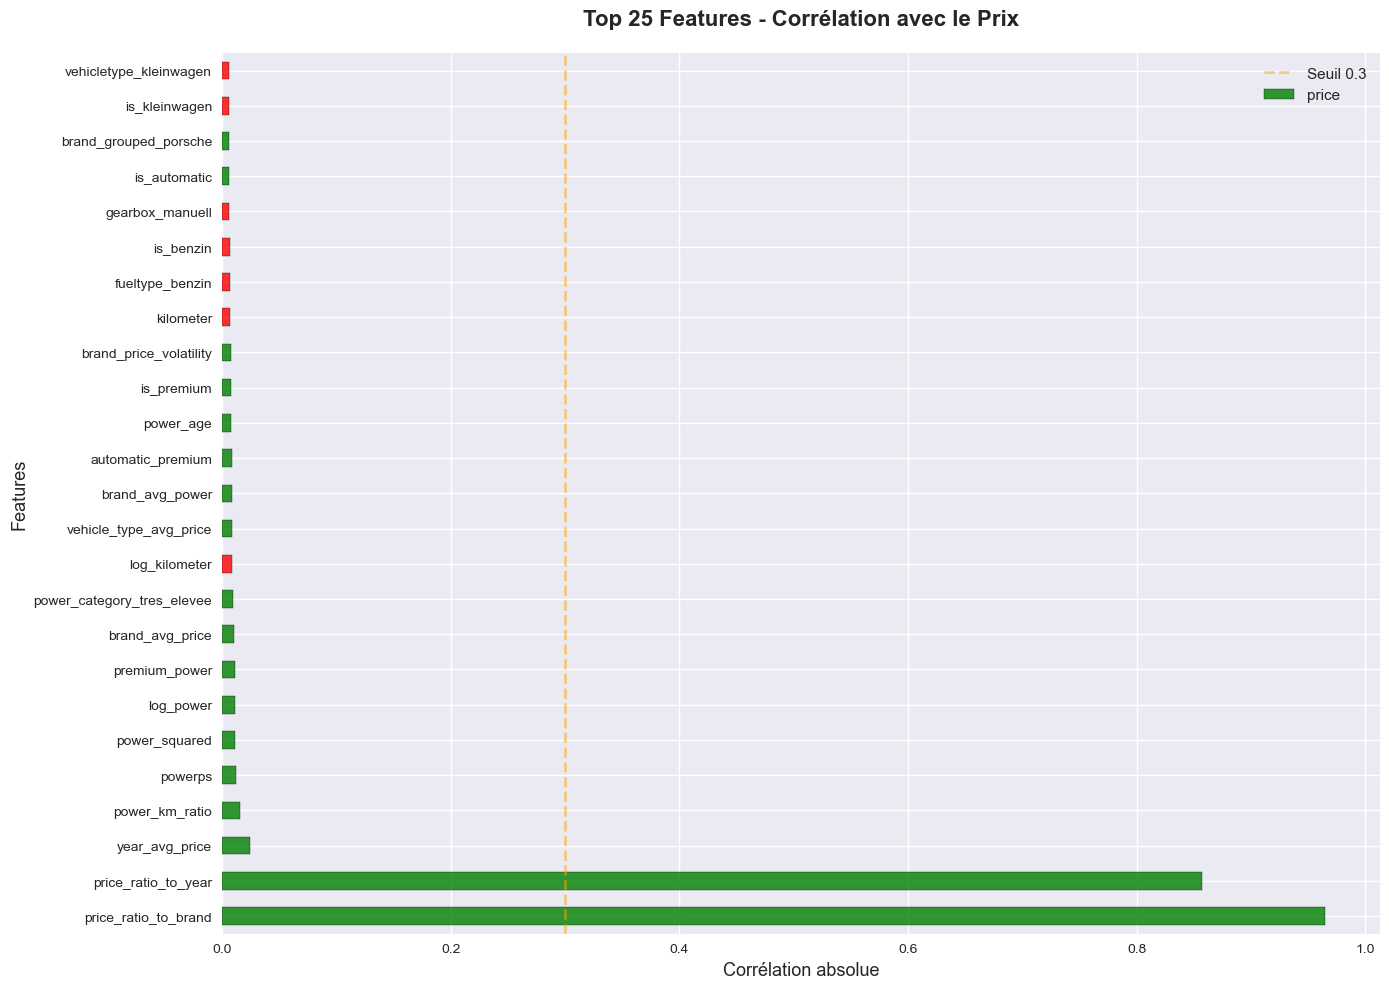

In [139]:
# Visualisation - Top 25 features
plt.figure(figsize=(14, 10))
top_corr = correlations.head(26)[1:]  # Exclure price lui-même
colors = ['green' if x > 0 else 'red' for x in df_final.corr()['price'][top_corr.index]]
top_corr.plot(kind='barh', color=colors, edgecolor='black', alpha=0.8)
plt.title('Top 25 Features - Corrélation avec le Prix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Corrélation absolue', fontsize=13)
plt.ylabel('Features', fontsize=13)
plt.axvline(x=0.3, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Seuil 0.3')
plt.legend(fontsize=11)
plt.tight_layout()
plt.savefig('feature_correlation_top25.png', dpi=300, bbox_inches='tight')
plt.show()

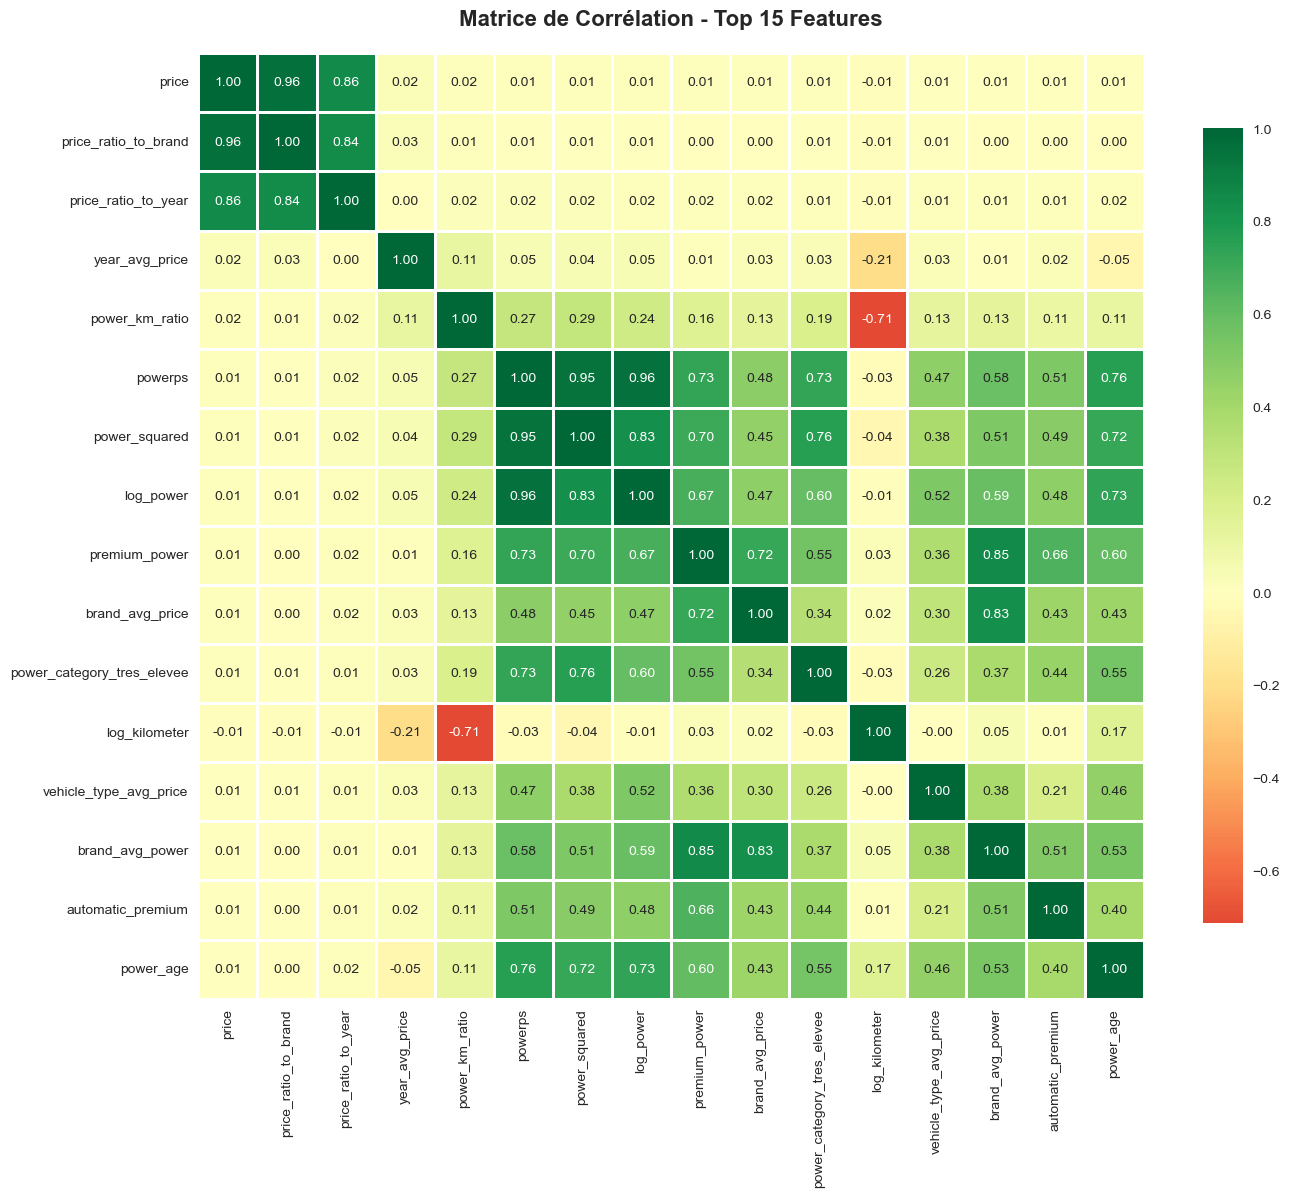

In [140]:
# Heatmap des top features
top_features = correlations.head(16).index.tolist()
plt.figure(figsize=(14, 12))
sns.heatmap(df_final[top_features].corr(),
            annot=True,
            cmap='RdYlGn',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=1,
            cbar_kws={"shrink": 0.8})
plt.title('Matrice de Corrélation - Top 15 Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [141]:
# Supprimer les features très corrélées entre elles (multicolinéarité)
print("\nDétection de la multicolinéarité...")
correlation_matrix = df_final.drop('price', axis=1).corr().abs()
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Trouver les features avec corrélation > 0.95
redundant = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]

if redundant:
    print(f"\nFeatures redondantes détectées (corrélation >0.95): {redundant}")
    print(f"Ces features seront supprimées pour éviter la multicolinéarité.")
    df_final = df_final.drop(columns=redundant)
    print(f"Shape après suppression: {df_final.shape}")
else:
    print("Aucune feature redondante détectée")


Détection de la multicolinéarité...

Features redondantes détectées (corrélation >0.95): ['car_age_squared', 'log_power', 'power_squared', 'age_km_interaction', 'damage_age', 'vehicletype_cabrio', 'vehicletype_kleinwagen', 'vehicletype_kombi', 'vehicletype_limousine', 'vehicletype_suv', 'gearbox_manuell', 'fueltype_benzin', 'fueltype_diesel', 'age_category_ancien']
Ces features seront supprimées pour éviter la multicolinéarité.
Shape après suppression: (274845, 80)


---
## 10. Export du Dataset Transformé

Sauvegarde du dataset final pour la modélisation.

In [142]:
# Vérifications finales
print("\nVérifications finales:")
print(f"Valeurs manquantes: {df_final.isnull().sum().sum()}")
print(f"Valeurs infinies: {np.isinf(df_final.select_dtypes(include=[np.number])).sum().sum()}")
print(f"Doublons: {df_final.duplicated().sum()}")
print(f"Shape finale: {df_final.shape}")


Vérifications finales:
Valeurs manquantes: 15732
Valeurs infinies: 0
Doublons: 26920
Shape finale: (274845, 80)


In [143]:
# Sauvegarder le dataset
# output_filename = 'autos_featured.csv'
# df_final.to_csv(output_filename, index=False)

# print(f"\nDataset sauvegardé: {output_filename}")
# import os
# print(f"Taille du fichier: {os.path.getsize(output_filename) / (1024*1024):.2f} MB")

In [144]:
# Test de chargement
# print("\nTest de chargement du fichier...")
# df_test = pd.read_csv(output_filename)
# print(f"Fichier chargé avec succès")
# print(f"Shape: {df_test.shape}")
# print(f"Colonnes: {df_test.shape[1]}")
# print(f"Lignes: {df_test.shape[0]:,}")

---
## 11. Résumé Final

Récapitulatif complet du feature engineering effectué.

In [145]:
print(f"""
STATISTIQUES GÉNÉRALES:
{'='*80}
   Dataset nettoyé (input):  {df.shape[0]:>8,} lignes × {df.shape[1]:>3} colonnes
   Dataset final (output):   {df_final.shape[0]:>8,} lignes × {df_final.shape[1]:>3} colonnes

   Features initiales:       {df.shape[1]:>8}
   Features finales:         {df_final.shape[1]-1:>8} (hors price)
   Features créées:          {(df_final.shape[1]-1) - df.shape[1]:>8}

QUALITÉ DES DONNÉES:
{'='*80}
   Valeurs manquantes:       {df_final.isnull().sum().sum():>8}
   Valeurs infinies:         {np.isinf(df_final.select_dtypes(include=[np.number])).sum().sum():>8}
   Doublons:                 {df_final.duplicated().sum():>8}

FEATURES CRÉÉES PAR CATÉGORIE:
{'='*80}

   NUMÉRIQUES (transformations):
      - car_age (âge du véhicule)
      - car_age_squared (âge au carré)
      - km_per_year (km par année)
      - log_kilometer (log du kilométrage)
      - log_power (log de la puissance)
      - power_squared (puissance au carré)
      - power_km_ratio (ratio puissance/km)

   CATÉGORIES (binning):
      - km_category (tres_faible, faible, moyen, eleve, tres_eleve)
      - age_category (neuf, recent, moyen, ancien)
      - power_category (faible, moyenne, elevee, tres_elevee)

   MARQUES (enrichissement):
      - brand_grouped (regroupement des marques rares)
      - is_premium (marques premium)
      - is_economy (marques économiques)
      - is_german (marques allemandes)

   CARACTÉRISTIQUES TECHNIQUES:
      - is_automatic (transmission automatique)
      - is_diesel, is_benzin, is_electric (type de carburant)
      - has_damage (dommages non réparés)
      - is_limousine, is_kombi, is_kleinwagen, is_suv, is_cabrio

   INTERACTIONS (combinaisons):
      - age_km_interaction
      - premium_age, premium_power
      - damage_age
      - automatic_premium
      - diesel_km
      - power_age

   AGRÉGATIONS (statistiques par groupe):
      - brand_avg_price (prix moyen par marque)
      - brand_price_volatility (volatilité du prix)
      - year_avg_price (prix moyen par année)
      - brand_popularity (nombre de voitures par marque)
      - brand_median_km (kilométrage médian par marque)
      - brand_avg_power (puissance moyenne par marque)
      - vehicle_type_avg_price (prix moyen par type)
      - price_ratio_to_brand (ratio prix/moyenne marque)
      - price_ratio_to_year (ratio prix/moyenne année)

TOP 10 FEATURES (corrélation avec le prix):
{'='*80}
""")

# Afficher le top 10
top_10 = correlations.head(11)[1:]  # Exclure price
for i, (feature, corr) in enumerate(top_10.items(), 1):
    print(f"   {i:2}. {feature:35s} -> {corr:.4f}")

print(f"""
PRÊT POUR LA MODÉLISATION:
{'='*80}
   Le fichier '{output_filename}' contient toutes les features transformées.
   Il peut maintenant être utilisé pour entraîner les modèles.

   Pour charger le dataset:
   >>> df = pd.read_csv('{output_filename}')
   >>> X = df.drop('price', axis=1)
   >>> y = df['price']

{'='*80}
FEATURE ENGINEERING TERMINÉ AVEC SUCCÈS
{'='*80}
""")


STATISTIQUES GÉNÉRALES:
   Dataset nettoyé (input):   274,845 lignes ×  51 colonnes
   Dataset final (output):    274,845 lignes ×  80 colonnes

   Features initiales:             51
   Features finales:               79 (hors price)
   Features créées:                28

QUALITÉ DES DONNÉES:
   Valeurs manquantes:          15732
   Valeurs infinies:                0
   Doublons:                    26920

FEATURES CRÉÉES PAR CATÉGORIE:

   NUMÉRIQUES (transformations):
      - car_age (âge du véhicule)
      - car_age_squared (âge au carré)
      - km_per_year (km par année)
      - log_kilometer (log du kilométrage)
      - log_power (log de la puissance)
      - power_squared (puissance au carré)
      - power_km_ratio (ratio puissance/km)

   CATÉGORIES (binning):
      - km_category (tres_faible, faible, moyen, eleve, tres_eleve)
      - age_category (neuf, recent, moyen, ancien)
      - power_category (faible, moyenne, elevee, tres_elevee)

   MARQUES (enrichissement):
      - br